In [1]:
%run 0_local_library_setup.ipynb

In [2]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager

import time

In [3]:
def spotify_get_all_results(access_token \
                            , endpoint \
                            , content_type \
                            , query = {} \
                            , max_parse_level = 0 \
                            , base_obj = None):
    api_call_headers = {
        'Authorization': 'Bearer ' + access_token,
        'Content-Type': content_type
    }

    next_api_url = endpoint

    first_call = True
    retVal_list = list()

    while next_api_url is not None:        
        api_request = requests.get(next_api_url, headers = api_call_headers, params = query if first_call else {})
        api_request.raise_for_status()

        api_request_json = api_request.json()
        
        if base_obj is not None:
            #Too simple for JMESPath...
            api_request_json = api_request_json[base_obj]

        if first_call:
            num_pages = int(np.ceil(api_request_json['total'] / api_request_json['limit']))

            desc_style = {'description_width': 'initial'}
            api_request_loading_bar = widgets.IntProgress(value = 0 \
                                                            , min = 0 \
                                                            , max = num_pages \
                                                            , description = 'Loading:' \
                                                            , bar_style = 'success' \
                                                            , orientation='horizontal' \
                                                            , style = desc_style\
                                                           )

            first_call = False

            display(api_request_loading_bar)

        next_api_url = api_request_json['next']

        retVal_list.append(pd.json_normalize(api_request_json['items'], max_level = max_parse_level))

        api_request_loading_bar.value += 1

        if api_request_loading_bar.value < num_pages:
            api_request_loading_bar.description = f'Loading Page: {api_request_loading_bar.value + 1} of {num_pages}'

    api_request_loading_bar.layout.display = 'none'
    
    return pd.concat(retVal_list).reset_index(drop = True)

In [4]:
driver = webdriver.Chrome(service = Service(ChromeDriverManager().install()))

spotify_accounts_endpoint = 'https://accounts.spotify.com/'
spotify_api_endpoint = 'https://api.spotify.com/v1/'

with open('config/config.yml', 'r') as file:
    config_contents = yaml.safe_load(file)
    
config_contents_creds = config_contents['creds']

client_id = config_contents_creds['client_id']
client_secret = config_contents_creds['client_secret']

redirect_uri = config_contents['redirect_uri']

oath_token_url = f'{spotify_accounts_endpoint}authorize?client_id={client_id}&response_type=code&redirect_uri={redirect_uri}&scope=user-read-private user-read-email playlist-read-private user-follow-read user-top-read user-read-recently-played user-library-read'

driver.get(oath_token_url)

username_input = driver.find_element('id', 'login-username')
username_input.send_keys(config_contents_creds['username'])

password_input = driver.find_element('id', 'login-password')
password_input.send_keys(config_contents_creds['password'])

login_button = driver.find_element('id', 'login-button')
login_button.click()

if (driver.current_url.startswith(f'{spotify_accounts_endpoint}en/authorize?')):
    agree_button = driver.find_element('xpath', '//button[@data-testid="auth-accept"]')
    agree_button.click()
    
time.sleep(2)
    
oauth_initial_token = driver.current_url.replace(f'{redirect_uri}/?code=', '')

driver.close()
driver.quit()

In [5]:
base64_encoding = 'ascii'
content_type_dictionary = {'Content-Type': 'application/x-www-form-urlencoded'}

get_bearer_token_headers = {
  'Authorization': 'Basic ' + \
                    base64.b64encode(f'{client_id}:{client_secret}'.encode(base64_encoding)).decode(base64_encoding)
} | content_type_dictionary

get_bearer_token_payload = {
    'grant_type': 'authorization_code',
    'code': oauth_initial_token,
    'redirect_uri': redirect_uri
}

get_bearer_token_response = requests.post(f'{spotify_accounts_endpoint}api/token' \
                                          , headers = get_bearer_token_headers \
                                          , data = get_bearer_token_payload)
get_bearer_token_response.raise_for_status()

get_bearer_token_response_json = get_bearer_token_response.json()
access_token = get_bearer_token_response_json['access_token']

In [6]:
track_str = 'track'
track_id_str = f'{track_str}_id'

my_tracks = spotify_get_all_results(access_token \
                                    , f'{spotify_api_endpoint}me/tracks' \
                                    , 'application/x-www-form-urlencoded' \
                                    , max_parse_level = 1)

my_tracks.columns = my_tracks.columns.str.replace(f'{track_str}.', '', regex = False)
my_tracks.rename(columns = {'id': track_id_str}, inplace = True)

display(my_tracks.head())
print(my_tracks.shape)

IntProgress(value=0, bar_style='success', description='Loading:', max=64, style=ProgressStyle(description_widt…

,added_at,album,artists,available_markets,disc_number,duration_ms,explicit,external_ids,external_urls,href,track_id,is_local,name,popularity,preview_url,track_number,type,uri
0,2022-11-06T19:14:52Z,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,884221,False,{'isrc': 'USC4R1706261'},{'spotify': 'https://open.spotify.com/track/3p...,https://api.spotify.com/v1/tracks/3piDdAdb4nsL...,3piDdAdb4nsLKe5tbM55gQ,False,Sharry Barry / Sliced Milk / 25 Or 6 To 4 / I'...,30,https://p.scdn.co/mp3-preview/3d807684258c6525...,4,track,spotify:track:3piDdAdb4nsLKe5tbM55gQ
1,2022-11-06T19:10:47Z,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,365394,False,{'isrc': 'USC4R1706260'},{'spotify': 'https://open.spotify.com/track/48...,https://api.spotify.com/v1/tracks/48Ycb0AAq6pv...,48Ycb0AAq6pvuj64rvAnBp,False,Slip Back,39,https://p.scdn.co/mp3-preview/bbab1d676458b71a...,3,track,spotify:track:48Ycb0AAq6pvuj64rvAnBp
2,2022-11-06T19:04:48Z,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,357353,False,{'isrc': 'USC4R1706259'},{'spotify': 'https://open.spotify.com/track/3S...,https://api.spotify.com/v1/tracks/3SK3XNzPZR2v...,3SK3XNzPZR2vnpcn5lcDZX,False,This Ol' Cowboy,44,https://p.scdn.co/mp3-preview/9b59050f5b0a9c52...,2,track,spotify:track:3SK3XNzPZR2vnpcn5lcDZX
3,2022-11-06T18:58:32Z,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,219443,False,{'isrc': 'USC4R1706258'},{'spotify': 'https://open.spotify.com/track/57...,https://api.spotify.com/v1/tracks/574W7rKfJVgk...,574W7rKfJVgkNTbOy746fP,False,What's Right,28,https://p.scdn.co/mp3-preview/fe939269f3e7070d...,1,track,spotify:track:574W7rKfJVgkNTbOy746fP
4,2022-11-06T18:53:21Z,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,169604,False,{'isrc': 'USUG12207839'},{'spotify': 'https://open.spotify.com/track/5p...,https://api.spotify.com/v1/tracks/5pk8bmS1pBY1...,5pk8bmS1pBY19ylTy6w6mO,False,It's Too Late - Spotify Singles,42,https://p.scdn.co/mp3-preview/99e2f7bff94579a3...,2,track,spotify:track:5pk8bmS1pBY19ylTy6w6mO


(1278, 18)


In [7]:
artists_str = 'artists'

track_artists_df = convert_json_col_to_dataframe_with_key(my_tracks, track_id_str, artists_str)

display(track_artists_df.head())
print(track_artists_df.shape)

,track_id,external_urls,href,id,name,type,uri
0,3piDdAdb4nsLKe5tbM55gQ,{'spotify': 'https://open.spotify.com/artist/0...,https://api.spotify.com/v1/artists/0tgaHqkU1p7...,0tgaHqkU1p7QhBUIzKXVU9,The Marcus King Band,artist,spotify:artist:0tgaHqkU1p7QhBUIzKXVU9
1,48Ycb0AAq6pvuj64rvAnBp,{'spotify': 'https://open.spotify.com/artist/0...,https://api.spotify.com/v1/artists/0tgaHqkU1p7...,0tgaHqkU1p7QhBUIzKXVU9,The Marcus King Band,artist,spotify:artist:0tgaHqkU1p7QhBUIzKXVU9
2,3SK3XNzPZR2vnpcn5lcDZX,{'spotify': 'https://open.spotify.com/artist/0...,https://api.spotify.com/v1/artists/0tgaHqkU1p7...,0tgaHqkU1p7QhBUIzKXVU9,The Marcus King Band,artist,spotify:artist:0tgaHqkU1p7QhBUIzKXVU9
3,574W7rKfJVgkNTbOy746fP,{'spotify': 'https://open.spotify.com/artist/0...,https://api.spotify.com/v1/artists/0tgaHqkU1p7...,0tgaHqkU1p7QhBUIzKXVU9,The Marcus King Band,artist,spotify:artist:0tgaHqkU1p7QhBUIzKXVU9
4,5pk8bmS1pBY19ylTy6w6mO,{'spotify': 'https://open.spotify.com/artist/0...,https://api.spotify.com/v1/artists/0FeWKiZSwBR...,0FeWKiZSwBRdGzqeCdlH1a,Marcus King,artist,spotify:artist:0FeWKiZSwBRdGzqeCdlH1a


(1455, 7)


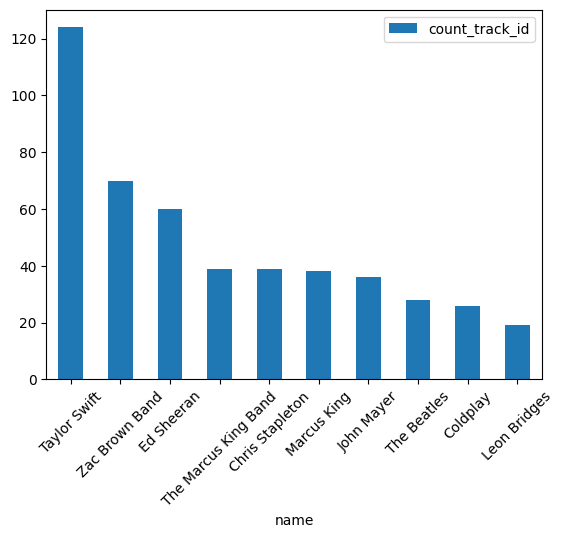

<Figure size 640x480 with 0 Axes>

In [8]:
id_str = 'id'
name_str = 'name'
count_track_id_str = f'count_{track_id_str}'

num_tracks_per_artist = track_artists_df.groupby([id_str, name_str])[track_id_str].count() \
                                        .to_frame().sort_values(track_id_str, ascending = False) \
                                        .reset_index().rename(columns = {track_id_str: count_track_id_str})

num_tracks_per_artist.head(10).plot(kind = 'bar', x = name_str, y = count_track_id_str, rot = 45)

plt.show()
plt.clf()

In [9]:
display(num_tracks_per_artist[num_tracks_per_artist[count_track_id_str] >= 2][[name_str, count_track_id_str]])

,name,count_track_id
0,Taylor Swift,124
1,Zac Brown Band,70
2,Ed Sheeran,60
3,The Marcus King Band,39
4,Chris Stapleton,39
5,Marcus King,38
6,John Mayer,36
7,The Beatles,28
8,Coldplay,26
9,Leon Bridges,19


In [10]:
display(num_tracks_per_artist[num_tracks_per_artist[count_track_id_str] == 1][[name_str, count_track_id_str]])

,name,count_track_id
167,Micah Nelson,1
168,O-Town,1
169,Macy Gray,1
170,Carrie Underwood,1
171,John Lennon,1
172,Harvey Danger,1
173,Matt Maeson,1
174,Skylar Grey,1
175,Four Tops,1
176,Brendon Urie,1


In [11]:
my_long_term_top_tracks = spotify_get_all_results(access_token \
                                                 , f'{spotify_api_endpoint}me/top/tracks' \
                                                 , 'application/json' \
                                                 , query = {'time_range': 'long_term'})

display(my_long_term_top_tracks)

IntProgress(value=0, bar_style='success', description='Loading:', max=3, style=ProgressStyle(description_width…

,album,artists,available_markets,disc_number,duration_ms,explicit,external_ids,external_urls,href,id,is_local,name,popularity,preview_url,track_number,type,uri
0,"{'album_type': 'ALBUM', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AR, AT, AU, BE, BG, BH, BO, BR, CA, C...",1,240600,False,{'isrc': 'USSM11800493'},{'spotify': 'https://open.spotify.com/track/1O...,https://api.spotify.com/v1/tracks/1Omt5bfz1tZU...,1Omt5bfz1tZUCqd26HxbS0,False,Beyond,72,https://p.scdn.co/mp3-preview/d292ddde93535d73...,4,track,spotify:track:1Omt5bfz1tZUCqd26HxbS0
1,"{'album_type': 'ALBUM', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AR, AT, AU, BE, BG, BH, BO, BR, CA, C...",1,613026,True,{'isrc': 'USUG12103690'},{'spotify': 'https://open.spotify.com/track/5e...,https://api.spotify.com/v1/tracks/5enxwA8aAbwZ...,5enxwA8aAbwZbf5qCHORXi,False,All Too Well (10 Minute Version) (Taylor's Ver...,83,https://p.scdn.co/mp3-preview/bfe8fd2f71ccfbee...,30,track,spotify:track:5enxwA8aAbwZbf5qCHORXi
2,"{'album_type': 'ALBUM', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AR, AT, AU, BE, BG, BH, BO, BR, CA, C...",1,218333,False,{'isrc': 'USC4R1802465'},{'spotify': 'https://open.spotify.com/track/2W...,https://api.spotify.com/v1/tracks/2WgbFkQQswVV...,2WgbFkQQswVVEWnyKnFo2q,False,All My Friends,51,https://p.scdn.co/mp3-preview/5331bb793e14d554...,2,track,spotify:track:2WgbFkQQswVVEWnyKnFo2q
3,"{'album_type': 'ALBUM', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AR, AT, AU, BE, BG, BH, BO, BR, CA, C...",1,196453,False,{'isrc': 'USRC12003754'},{'spotify': 'https://open.spotify.com/track/1d...,https://api.spotify.com/v1/tracks/1daDRI9ahBon...,1daDRI9ahBonbWD8YcxOIB,False,Angels Like You,78,https://p.scdn.co/mp3-preview/3cf4c45d328d5ba3...,3,track,spotify:track:1daDRI9ahBonbWD8YcxOIB
4,"{'album_type': 'ALBUM', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AR, AT, AU, BE, BG, BH, BO, BR, CA, C...",1,294520,True,{'isrc': 'USUG12002848'},{'spotify': 'https://open.spotify.com/track/3I...,https://api.spotify.com/v1/tracks/3IhtE4fkytdr...,3IhtE4fkytdrtEfV34UzkD,False,betty,64,https://p.scdn.co/mp3-preview/9dd54ccc09528313...,14,track,spotify:track:3IhtE4fkytdrtEfV34UzkD
5,"{'album_type': 'ALBUM', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AR, AT, AU, BE, BG, BH, BO, BR, CA, C...",1,285640,False,{'isrc': 'USUG12002838'},{'spotify': 'https://open.spotify.com/track/5S...,https://api.spotify.com/v1/tracks/5S4aYQAJOwJM...,5S4aYQAJOwJMAamANWlICO,False,exile (feat. Bon Iver),67,https://p.scdn.co/mp3-preview/2baf74134138b19b...,4,track,spotify:track:5S4aYQAJOwJMAamANWlICO
6,"{'album_type': 'ALBUM', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AR, AT, AU, BE, BG, BH, BO, BR, CA, C...",1,298666,False,{'isrc': 'USUM70760674'},{'spotify': 'https://open.spotify.com/track/2Z...,https://api.spotify.com/v1/tracks/2ZkbT2NZYVdA...,2ZkbT2NZYVdAk14puSae5a,False,Turning Home,35,https://p.scdn.co/mp3-preview/b0c4608d3d2f5e24...,10,track,spotify:track:2ZkbT2NZYVdAk14puSae5a
7,"{'album_type': 'ALBUM', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AR, AT, AU, BE, BG, BH, BO, BR, CA, C...",1,285106,True,{'isrc': 'USUG12103686'},{'spotify': 'https://open.spotify.com/track/4C...,https://api.spotify.com/v1/tracks/4CkgMiMqZ5Jz...,4CkgMiMqZ5JzW9iYXSTMTL,False,I Bet You Think About Me (feat. Chris Stapleto...,74,https://p.scdn.co/mp3-preview/45260aa995e2d521...,26,track,spotify:track:4CkgMiMqZ5JzW9iYXSTMTL
8,"{'album_type': 'ALBUM', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AR, AT, AU, BE, BG, BH, BO, BR, CA, C...",1,170826,False,{'isrc': 'GBAHS1700026'},{'spotify': 'https://open.spotify.com/track/0a...,https://api.spotify.com/v1/tr

In [12]:
#TODO top songs by artist

In [13]:
my_followed_artists = spotify_get_all_results(access_token \
                                              , f'{spotify_api_endpoint}me/following' \
                                              , 'application/json' \
                                              , query = {'type': 'artist'} \
                                              , base_obj = 'artists')

display(my_followed_artists)

IntProgress(value=0, bar_style='success', description='Loading:', max=2, style=ProgressStyle(description_width…

,external_urls,followers,genres,href,id,images,name,popularity,type,uri
0,{'spotify': 'https://open.spotify.com/artist/0...,"{'href': None, 'total': 38410519}",[pop],https://api.spotify.com/v1/artists/04gDigrS5kc...,04gDigrS5kc9YWfZHwBETP,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",Maroon 5,84,artist,spotify:artist:04gDigrS5kc9YWfZHwBETP
1,{'spotify': 'https://open.spotify.com/artist/0...,"{'href': None, 'total': 61371943}",[pop],https://api.spotify.com/v1/artists/06HL4z0CvFA...,06HL4z0CvFAxyc27GXpf02,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",Taylor Swift,100,artist,spotify:artist:06HL4z0CvFAxyc27GXpf02
2,{'spotify': 'https://open.spotify.com/artist/0...,"{'href': None, 'total': 18601763}","[alternative rock, funk metal, funk rock, perm...",https://api.spotify.com/v1/artists/0L8ExT028jH...,0L8ExT028jH3ddEcZwqJJ5,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",Red Hot Chili Peppers,82,artist,spotify:artist:0L8ExT028jH3ddEcZwqJJ5
3,{'spotify': 'https://open.spotify.com/artist/0...,"{'href': None, 'total': 44039222}","[dance pop, pop]",https://api.spotify.com/v1/artists/0du5cEVh5yT...,0du5cEVh5yTK9QJze8zA0C,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",Bruno Mars,86,artist,spotify:artist:0du5cEVh5yTK9QJze8zA0C
4,{'spotify': 'https://open.spotify.com/artist/0...,"{'href': None, 'total': 5667692}","[neo mellow, singer-songwriter]",https://api.spotify.com/v1/artists/0hEurMDQu99...,0hEurMDQu99nJRq8pTxO14,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",John Mayer,76,artist,spotify:artist:0hEurMDQu99nJRq8pTxO14
5,{'spotify': 'https://open.spotify.com/artist/0...,"{'href': None, 'total': 1557440}","[alternative rock, neo mellow, pop rock, rock]",https://api.spotify.com/v1/artists/0vEsuISMWAK...,0vEsuISMWAKNctLlUAhSZC,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",Counting Crows,67,artist,spotify:artist:0vEsuISMWAKNctLlUAhSZC
6,{'spotify': 'https://open.spotify.com/artist/0...,"{'href': None, 'total': 3747179}","[neo mellow, piano rock, pop, pop rock]",https://api.spotify.com/v1/artists/0zOcE3mg9nS...,0zOcE3mg9nS6l3yxt1Y0bK,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",The Fray,67,artist,spotify:artist:0zOcE3mg9nS6l3yxt1Y0bK
7,{'spotify': 'https://open.spotify.com/artist/1...,"{'href': None, 'total': 21636248}",[pop],https://api.spotify.com/v1/artists/1McMsnEElTh...,1McMsnEElThX1knmY4oliG,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",Olivia Rodrigo,83,artist,spotify:artist:1McMsnEElThX1knmY4oliG
8,{'spotify': 'https://open.spotify.com/artist/1...,"{'href': None, 'total': 43435098}","[classic rock, glam rock, rock]",https://api.spotify.com/v1/artists/1dfeR4HaWDb...,1dfeR4HaWDbWqFHLkxsg1d,"[{'height': 806, 'url': 'https://i.scdn.co/ima...",Queen,83,artist,spotify:artist:1dfeR4HaWDbWqFHLkxsg1d
9,{'spotify': 'https://open.spotify.com/artist/1...,"{'href': None, 'total': 1112650}","[neo mellow, pop punk, pop rock]",https://api.spotify.com/v1/artists/1g1yxsNVPhM...,1g1yxsNVPhMUl9GrMjEb2o,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",Plain White T's,63,artist,spotify:artist:1g1yxsNVPhMUl9GrMjEb2o


In [14]:
my_track_artists = num_tracks_per_artist[[id_str, name_str, count_track_id_str]]

display(my_track_artists)

,id,name,count_track_id
0,06HL4z0CvFAxyc27GXpf02,Taylor Swift,124
1,6yJCxee7QumYr820xdIsjo,Zac Brown Band,70
2,6eUKZXaKkcviH0Ku9w2n3V,Ed Sheeran,60
3,0tgaHqkU1p7QhBUIzKXVU9,The Marcus King Band,39
4,4YLtscXsxbVgi031ovDDdh,Chris Stapleton,39
...,...,...,...
506,2rblp9fJo16ZPTcKDtlmKW,MC Hammer,1
507,2qwXeRk8VBAegbUnf3xdyi,Ashley Cooke,1
508,2qc41rNTtdLK0tV3mJn2Pm,Ryan Adams,1
509,2qFr8w5sWUITRlzZ9kZotF,Jefferson Airplane,1


In [15]:
my_left = my_track_artists
my_right = my_followed_artists

my_followed_and_liked_artists_df = pd.merge(my_left \
                                            , my_right \
                                            , on = id_str \
                                            , how = 'inner' \
                                            , suffixes = ('', '_y'))[my_left.columns]

display(my_followed_and_liked_artists_df)
print(my_followed_and_liked_artists_df.shape)

,id,name,count_track_id
0,06HL4z0CvFAxyc27GXpf02,Taylor Swift,124
1,6yJCxee7QumYr820xdIsjo,Zac Brown Band,70
2,6eUKZXaKkcviH0Ku9w2n3V,Ed Sheeran,60
3,4YLtscXsxbVgi031ovDDdh,Chris Stapleton,39
4,0hEurMDQu99nJRq8pTxO14,John Mayer,36
5,3WrFJ7ztbogyGnTHbHJFl2,The Beatles,28
6,4gzpq5DPGxSnKTe4SA8HAU,Coldplay,26
7,3qnGvpP8Yth1AqSBMqON5x,Leon Bridges,19
8,0L8ExT028jH3ddEcZwqJJ5,Red Hot Chili Peppers,18
9,7oPftvlwr6VrsViSDV7fJY,Green Day,18


(34, 3)


In [16]:
my_track_artists_ids = set(my_left[id_str])
my_followed_artists_ids = set(my_right[id_str])
my_followed_and_liked_artists_ids = set(my_followed_and_liked_artists_df[id_str])

my_unfollowed_track_artists_ids = my_track_artists_ids - my_followed_and_liked_artists_ids
my_followed_and_nonliked_artists_ids = my_followed_artists_ids - my_followed_and_liked_artists_ids

#TODO handle when my_followed_and_nonliked_artists_ids is non-empty

my_unfollowed_track_artists_df = my_left[my_left[id_str].isin(my_unfollowed_track_artists_ids)]

my_top_unfollowed_artists_indices = my_unfollowed_track_artists_df[count_track_id_str] > 2

my_top_unfollowed_artists_df = my_unfollowed_track_artists_df[my_top_unfollowed_artists_indices] \
                                    .reset_index(drop = True)

display(my_top_unfollowed_artists_df)
print(my_top_unfollowed_artists_df.shape)

,id,name,count_track_id
0,0tgaHqkU1p7QhBUIzKXVU9,The Marcus King Band,39
1,0FeWKiZSwBRdGzqeCdlH1a,Marcus King,38
2,6WY7D3jk8zTrHtmkqqo5GI,Maren Morris,16
3,3UUJfRbrA2nTbcg4i0MOwu,Original Broadway Cast of Hamilton,9
4,4wQ3PyMz3WwJGI5uEqHUVR,Allman Brothers Band,9
5,4DZGvSv2oMkBUnPz67E6z6,David Nail,9
6,5kuJibJcwOC53s3OkoGMRA,The Revivalists,8
7,3M4ThdJR28z9eSMcQHAZ5G,The Fratellis,8
8,58lV9VcRSjABbAbfWS6skp,Bon Jovi,7
9,4aXXDj9aZnlshx7mzj3W1N,Lin-Manuel Miranda,7


(65, 3)
